In [21]:
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer, setup_chat_format

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
import re

import os

In [22]:
# Count GPUs
print("Available GPUs:", torch.cuda.device_count())

# Set CUDA_VISIBLE_DEVICES to use only GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Count GPUs again to see if the change took effect
print("Available GPUs after setting CUDA_VISIBLE_DEVICES:", torch.cuda.device_count())

# Move the model to the appropriate device
device = torch.device("cuda:1") 
print("Using device:", device)

Available GPUs: 1
Available GPUs after setting CUDA_VISIBLE_DEVICES: 1
Using device: cuda:1


In [ ]:
seed = 42

data = pd.read_csv('/home/hda12228/Legal_Relevance/FOR_FINE_TUNE/input.tsv',  delimiter='\t', encoding='utf-8')
data.reset_index(drop=True, inplace=True)

system_message = """
"""

dataset_tr, dataset_test = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=seed)

def convert_dataset(data):
    prompt= [{"role": "system", "content": system_message}, 
             {"role": "user", "content": str(data["input"])},
             {"role": "assistant", "content": str(data["label"])}]
    return {'messages': prompt}

dataset_tr = Dataset.from_pandas(dataset_tr)
dataset_t = Dataset.from_pandas(dataset_test)

dataset_tr = dataset_tr.map(convert_dataset, remove_columns=dataset_tr.features)
dataset_t = dataset_t.map(convert_dataset, remove_columns=dataset_t.features)
print(dataset_tr[1]["messages"])
 
#dataset_tr.to_json("train_dataset.json", orient="records")
#dataset_t.to_json("test_dataset.json", orient="records")

In [24]:
PATH = ''
FT_PATH = ''

### Training with LoRA

In [28]:
llama_tokenizer = AutoTokenizer.from_pretrained(PATH, trust_remote_code=True)
llama_tokenizer.padding_side = "right"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    #load_in_8bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False
)

base_model = AutoModelForCausalLM.from_pretrained(
    PATH,
    quantization_config=quant_config,
    device_map={"": 0}
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

model, tokenizer = setup_chat_format(base_model, llama_tokenizer)

peft_parameters = LoraConfig(
    lora_alpha=256,
    lora_dropout=0.1,
    r=256,
    bias="none",
    task_type="CAUSAL_LM"

)

train_params = TrainingArguments(
    output_dir='',
    #num_train_epochs=6,
    num_train_epochs=8,
    per_device_train_batch_size=4,
    #per_device_train_batch_size=2,
    gradient_accumulation_steps=1, #default 1
    optim='paged_adamw_32bit',
    save_steps=100,
    logging_steps=100,
    learning_rate=2e-4,
    #learning_rate=5e-5,
    weight_decay=0.001,
    #fp16=False, #false by default
    #bf16=False, #false by default
    #max_grad_norm=0.3, # default to 1.0
    max_grad_norm=1.0, # default to 1.0
    warmup_ratio=0.03, # default to 0.0
    group_by_length=True,
    #lr_scheduler_type="constant",
    lr_scheduler_type='linear',
    seed=seed
)

ft = SFTTrainer(
    model=model,
    train_dataset=dataset_tr,
    peft_config=peft_parameters,
    tokenizer=tokenizer,
    args=train_params,
    max_seq_length=512,
)

ft.train()
ft.model.save_pretrained(FT_PATH)
tokenizer.save_pretrained(FT_PATH)

# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/959 [00:00<?, ? examples/s]

Step,Training Loss
100,1.081000
200,0.885800
300,0.851600
400,0.779800
500,0.726300
600,0.777300
700,0.631200
800,0.564000
900,0.553600
1000,0.484600


/home/hda12228/botox/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /media/data/uv/Meta-Llama-3-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/home/hda12228/botox/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /media/data/uv/Meta-Llama-3-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/home/hda12228/botox/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /media/data/uv/Meta-Llama-3-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/home/hda12228/botox/lib/python3.10/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /media/data/uv/Meta-Llama-3-8B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/home/hda12228/botox/lib/python3.10/site-packages/pe

In [29]:
del model, tokenizer, llama_tokenizer, ft, base_model

### Merge the trained parameters and the base model

In [30]:
merged_model_path = ''

base_model = AutoModelForCausalLM.from_pretrained(PATH, low_cpu_mem_usage=True, return_dict=True, torch_dtype=torch.float16, device_map={"": 0})
model = PeftModel.from_pretrained(base_model, FT_PATH)

model = model.merge_and_unload()
model.save_pretrained(merged_model_path)
print('The merged model saved')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The merged model saved


In [31]:
merged_model_path = "/media/data/uv/llama-8b-criminal-paragraphs-merged"

fine_tuned_model = AutoModelForCausalLM.from_pretrained(merged_model_path)
print('The merged model uploaded')

tokenizer = AutoTokenizer.from_pretrained(PATH, trust_remote_code=True)
print('The tokenizer uploaded')

text_generator = pipeline("text-generation", model=fine_tuned_model, tokenizer=tokenizer)
print('The pipeline initialized')


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The merged model uploaded
The tokenizer uploaded
The pipeline initialized


In [ ]:
test_sample = dataset_t[0]

generated_texts = []

for idx, data in enumerate(dataset_t):
    prompt = tokenizer.apply_chat_template(data["messages"][:2], tokenize=False, add_generation_prompt=True)

    outputs = text_generator(
        prompt,
        max_new_tokens=1,
        do_sample=True,
        temperature=0.1,
        top_k=10,
        top_p=0.1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id
    )
    print(f'The prompt for index {idx} generated')
    generated_texts.append(outputs[0]['generated_text'])
print('The test texts generated')

### Inference phase

In [33]:

true_labels = dataset_test['label'].tolist()
predicted_labels = [int(text.split()[-1]) if text.split()[-1].isdigit() else -1 for text in generated_texts]

output= {'comment' : dataset_test['input'],
         'label' : dataset_test['label'], 
         'pred' : predicted_labels,
         'full_pred' : generated_texts
                     }
    
output = pd.DataFrame(output)

In [34]:
#Search for the pattern 
pattern = "([^/]+$)"
match = re.search(pattern, PATH)
output.to_csv(f'predictions_{match.group(1)}.tsv', sep="\t")

Accuracy: 0.8583333333333333
F1-score: 0.8593041007200861


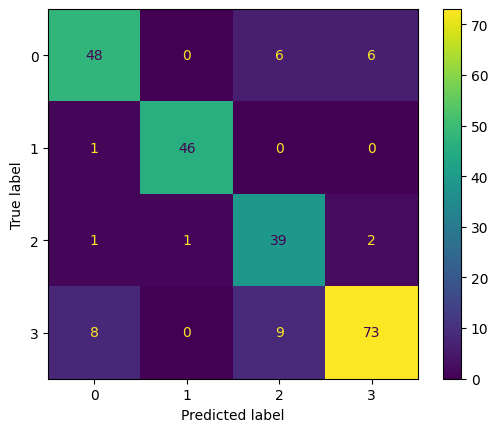

In [35]:

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

f_score = f1_score(true_labels, predicted_labels, average='weighted')
print("F1-score:", f_score)

class_labels = [0, 1, 2, 3]
cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels)
disp.plot()
plt.savefig(f'predictions_{match.group(1)}', dpi=300)
